<div style="text-align: right;">
<a target="_blank" href="https://colab.research.google.com/github/hkaragah/hkaragah.github.io/blob/main/structure/opensees/two_story_mrf.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
<div style="font-size: 0.8em; color: #555;">By Hossein Karagah</div>
<div style="font-size: 0.8em; color: #555;">© Copyright 2025 GNU GENERAL PUBLIC LICENSE.</div>
</div>

# OpenSees: Three-Story MRF Analysis

### Import Dependencies

In [1]:
from __future__ import annotations
from dataclasses import dataclass
import os
import sys
sys.path.append(os.path.abspath("../.."))
from assets.modules.shapes import AISC_WSection
from assets.modules.materials import SteelSectionCategories, ASTMSteel
import openseespywin.opensees as ops
from math import prod, pi, sqrt
import pandas as pd
import matplotlib.pyplot as plt

### Define Materials and Sections

In [2]:
# Define steel material
E = 29000 # ksi
Fy = 50.0 # ksi
cat = SteelSectionCategories.HOT_ROLLED
A992 = ASTMSteel('A992', cat, Fy, E)

# Define beam and column sections
bm = AISC_WSection('W10X26')
col = AISC_WSection('W8X48')

### Define Plastic Hinge Material

In [3]:
# Compute Bilin material parameters

# Regression coefficients from Lignos & Krawinkler (2011)
A = {
    'd<21': {
#                            h/tw    bf/2tf  Lb/ry  L/d    c1*d    c2*Fy
        'theta_p':  [0.0865, -0.365, -0.140, 0.000, 0.340, -0.721, -0.230],
        'theta_pc': [5.6300, -0.565, -0.800, 0.000, 0.000, -0.280, -0.430],
        'lambda':   [495.00, -1.340, -0.595, 0.000, 0.000,  0.000, -0.360]
    },
    'd>=21': {
        'theta_p':  [0.3180, -0.550, -0.345, -0.023, 0.090, -0.330, -0.130],
        'theta_pc': [7.5000, -0.610, -0.710, -0.110, 0.000, -0.161, -0.320],
        'lambda':   [536.00, -1.260, -0.525, -0.130, 0.000,  0.000, -0.291]
    },
    'rbs': {
        'theta_p':  [0.1900, -0.314, -0.100, -0.185, 0.113, -0.760, -0.070],
        'theta_pc': [9.5200, -0.513, -0.863, -0.108, 0.000,  0.000, -0.360],
        'lambda':   [585.00, -1.140, -0.632, -0.205, 0.000,  0.000, -0.391]
    }
}



def _LK(sec: AISC_WSection, is_rbs: bool,mat: ASTMSteel, L: float, Lb: float | None = None) -> dict:
    """
    Lignos–Krawinkler median regressions RBS or WUF-B connections:
    Returns theta_p, theta_pc, Lambda, theta_u.
    """
    Fy = mat.fy
    d = sec.d
    ry = sec.ry
    htw = sec.htw
    bf2tf = sec.bf2tf
    if not Lb:
        Lb = 2500 / mat.fy
    Lbry = Lb / ry
    Ld = L / d
    c1 = c2 = 1.0  # inch/ksi units
        
    if is_rbs:
        A_ = A['rbs']
    else:
        A_ = A['d<21'] if d < 21.0 else A['d>=21']
    
    KL_params ={}
    for key in A_.keys(): # keys: 'theta_p', 'theta_pc', 'lambda'
        a = A_[key]
        KL_params[key] = prod([
            a[0],
            htw**(a[1]),
            bf2tf**(a[2]),
            Lbry**(a[3]),
            Ld**(a[4]),
            (c1*d/533)**(a[5]),
            (c2*Fy/355)**(a[6])
            ])

    # Ultimate rotation capacity (theta_u)
    # See Lignos & Krawinkler, 2011, Ultimate Rotation Capacity Section
    KL_params['theta_u']  = 0.06 if is_rbs else 0.05 # radians
    
    return KL_params


def _K0_from_hinge(sec: AISC_WSection, mat: ASTMSteel, My: float, Lp: float | None):
    """
    K0 = My / theta_y, with theta_y ≈ (My/(E*Ig)) * Lp.  Default Lp = 0.8*d.
    """
    E, Ig = mat.E, sec.Ix
    Lp = 0.8*sec.d if Lp is None else Lp
    phi_y   = My/(E*Ig)      # 1/in
    theta_y = phi_y*Lp       # rad
    return My/theta_y        # kip-in/rad


def compute_bilin_params_wufb(
    sec: AISC_WSection,
    is_rbs: bool,
    mat: ASTMSteel,
    L: float,                   # in, shear span (hinge to inflection)
    Lb: float | None = None,    # in, unbraced length (default 2500/Fy)
    Lp: float | None = None,    # in, hinge length (default 0.8d)
    as_pos: float = 0.02,       # post-yield hardening ratio (+)
    as_neg: float = 0.02,       # post-yield hardening ratio (–)
    Res_pos: float = 0.20,      # residual strength ratio (+)
    Res_neg: float = 0.20,      # residual strength ratio (–)
    c_S: float = 1.0, c_C: float = 1.0, c_K: float = 1.0,
    D_pos: float = 1.0, D_neg: float = 1.0,
    nFactor: float = 0.0        # elastic stiffness amplifier (optional)
):
    """
    Returns:
      params: dict of Bilin arguments
      cmd:    ready-to-paste OpenSeesPy 'uniaxialMaterial("Bilin", ...)' line
    """
    # Effective yield moment (take sign in command):
    My = mat.Ry * mat.fy * sec.Zx  # kip-in

    # Lignos–Krawinkler non-RBS (WUF-B) medians
    KL_params = _LK(sec, is_rbs, mat, L)

    # Elastic stiffness
    K0 = _K0_from_hinge(sec, mat, My, Lp)

    # Bilin expects Lamda_A although accel-reload deterioration is not active for Bilinear;
    # pass a huge number to effectively disable it.
    Lamda_S = Lamda_C = Lamda_K = KL_params['lambda']
    Lamda_A = 1.0e16

    params = dict(
        K0=K0,
        as_Plus=as_pos, as_Neg=as_neg,
        My_Plus=+My,   My_Neg=-My,
        Lamda_S=Lamda_S, Lamda_C=Lamda_C, Lamda_A=Lamda_A, Lamda_K=Lamda_K,
        c_S=c_S, c_C=c_C, c_A=1.0, c_K=c_K,
        theta_p_Plus=KL_params['theta_p'], theta_p_Neg=KL_params['theta_p'],
        theta_pc_Plus=KL_params['theta_pc'], theta_pc_Neg=KL_params['theta_pc'],
        Res_Pos=Res_pos, Res_Neg=Res_neg,
        theta_u_Plus=KL_params['theta_u'], theta_u_Neg=KL_params['theta_u'],
        D_Plus=D_pos, D_Neg=D_neg,
        nFactor=nFactor
    )

    cmd = (
        "ops.uniaxialMaterial('Bilin', matTag, "
        f"{params['K0']:.6g}, {params['as_Plus']:.6g}, {params['as_Neg']:.6g}, "
        f"{params['My_Plus']:.6g}, {params['My_Neg']:.6g}, "
        f"{params['Lamda_S']:.6g}, {params['Lamda_C']:.6g}, {params['Lamda_A']:.6g}, {params['Lamda_K']:.6g}, "
        f"{params['c_S']:.6g}, {params['c_C']:.6g}, {params['c_A']:.6g}, {params['c_K']:.6g}, "
        f"{params['theta_p_Plus']:.6g}, {params['theta_p_Neg']:.6g}, {params['theta_pc_Plus']:.6g}, {params['theta_pc_Neg']:.6g}, "
        f"{params['Res_Pos']:.6g}, {params['Res_Neg']:.6g}, "
        f"{params['theta_u_Plus']:.6g}, {params['theta_u_Neg']:.6g}, "
        f"{params['D_Plus']:.6g}, {params['D_Neg']:.6g}"
        f"{'' if params['nFactor']==0 else ', ' + str(params['nFactor'])}"  # optional
        ")"
    )
    return params, cmd

In [4]:
params, cmd = compute_bilin_params_wufb(
    sec=bm,
    is_rbs=False,
    mat=A992,
    L=0.8*20*12
)

### Define Model

In [5]:
###############
# Reset Model #
###############

ops.wipe()



################
# Create Model #
################

# 2 dimensions, 3 DOF per node
ops.model('basic', '-ndm', 2, '-ndf', 3)

#### Units are inches, kips, seconds ####

# Define variables
story_height = 12 * 12 # inches
span = 20 * 12 # inches
nStoreis = 3
nBays = 1
nodeTags = {}



################
# Define Nodes #
################

for story in range(nStoreis + 1):
    for bay in range(nBays + 1):
        
        nodeTag = 10 * story + bay + 1
        x = bay * span
        y = story * story_height
        ops.node(nodeTag, x, y)
        nodeTags[(story, bay)] = nodeTag
        
        # Define extra node in the same coordinate for beam plastic hinges
        if story != 0:
            nodeTagPH = (10 * story + bay + 1) * 10
            ops.node(nodeTagPH, x, y)
            nodeTags[(story, bay, 'PH')] = nodeTagPH
            ops.equalDOF(nodeTagPH, nodeTag, 1, 2) # Tie translational DOFs (UX an UY)
            
        # Fix base nodes
        if story == 0:
            ops.fix(nodeTag, 1, 1, 1)



####################
# Define Materials #
####################

b = 0.01 # initial hardening ratio
matTags = [1, 2, 3]

# Nonlinear steel material
ops.uniaxialMaterial('Steel01', matTags[0], A992.fy, A992.E, b)

# elastic steel material
ops.uniaxialMaterial('Elastic', matTags[1], E)

# Define bilin material for plastic hinges
ops.uniaxialMaterial('IMKBilin', matTags[2], 
    params['K0'], params['as_Plus'], params['as_Neg'],
    params['My_Plus'], params['My_Neg'],
    params['Lamda_S'], params['Lamda_C'], params['Lamda_A'], params['Lamda_K'],
    params['c_S'], params['c_C'], params['c_A'], params['c_K'],
    params['theta_p_Plus'], params['theta_p_Neg'],
    params['theta_pc_Plus'], params['theta_pc_Neg'],
    params['Res_Pos'], params['Res_Neg'],
    params['theta_u_Plus'], params['theta_u_Neg'],
    params['D_Plus'], params['D_Neg']
)


coordTransf = "PDelta"  # Linear, PDelta, Corotational
transfTag = 1
ops.geomTransf(coordTransf, transfTag)



###################
# Define Sections #
###################

colSecTag = 1                         
Nfw = 8 # number of fibers in web
Nff = 8 # number of fibers in flange
ops.section('WFSection2d', colSecTag, matTags[0], col.d, col.tw, col.bf, col.tf, Nfw, Nff)

bmSecTag = 2
ops.section('Elastic', bmSecTag, A992.E, bm.A, bm.Ix)



###################
# Define Elements #
###################

nIntPoints = 4 # max = 10
eleTags = {'col': {}, 'bm': {}, 'ph': {}}
for story in range(nStoreis):

    for bay in range(nBays + 1):

        # Define one column element per story/bay (nonlinear beam-column element)
        colEleTag = 100 * (story + 1) + (bay + 1)
        nodeTag = (nodeTags[(story, bay)], nodeTags[(story + 1, bay)])
        ops.element('nonlinearBeamColumn', colEleTag, *nodeTag, nIntPoints, colSecTag, transfTag)
        eleTags['col'][colEleTag] = nodeTag
                
    for bay in range(nBays):
            
        # Define one beam element per story/bay (elastic beam-column element)
        bmEleTag = 100 * (story + 1) + 10 + (bay + 1)
        nodeTag = (nodeTags[(story + 1, 0, 'PH')], nodeTags[(story + 1, 1, 'PH')])
        ops.element('elasticBeamColumn', bmEleTag, *nodeTag, bmSecTag, transfTag)
        eleTags['bm'][bmEleTag] = nodeTag
        
        # Define beam left plastic hinges (zeoro-length element with Bilin material)
        phEleTag = 10 * bmEleTag
        nodeTag = (nodeTags[(story + 1, 0)], nodeTags[(story + 1, 0, 'PH')])
        ops.element('zeroLength', phEleTag, *nodeTag, '-mat', matTags[2], '-dir', 6)
        eleTags['ph'][phEleTag] = nodeTag
        
        # Define beam right plastic hinges (zeoro-length element with Bilin material)
        nodeTag = (nodeTags[(story + 1, 1)], nodeTags[(story + 1, 1, 'PH')])
        ops.element('zeroLength', phEleTag + 1, *nodeTag, '-mat', matTags[2], '-dir', 6)
        eleTags['ph'][phEleTag + 1] = nodeTag



########################
# Define Gravity Loads #
########################

tsTag = 1
ops.timeSeries('Linear', tsTag, '-factor', 1.0)

DL = 0.5 # k/in, distributed load
CL = 15 # kips, concentrated load

patternTag = 1
# Define loads in gravity direction (-UY)
ops.pattern('Plain', patternTag, tsTag)

ops.load(11, 0.0, -CL/2, 0.0), 
ops.load(12, 0.0, -CL/2, 0.0), 
ops.load(21, 0.0, -CL/2, 0.0),
ops.load(22, 0.0, -CL/2, 0.0),
ops.load(31, 0.0, -CL/2, 0.0),
ops.load(32, 0.0, -CL/2, 0.0),
ops.eleLoad('-ele', *[111, 211, 311], '-type', '-beamUniform', -DL)


#################
# Define Masses #
#################

# Define masses in the lateral direction only (UX)
# 75 tonf x 2.205 kip/tonf = 165.375 kip
# g = 32.2 ft/s²
# 165.375 kip / g = 5.14 tonf·s²/ft (5140 lb·s²/in or slugs)
ops.mass(11, 2.6, 0.0, 0.0) # half goes to each floor node
ops.mass(12, 2.6, 0.0, 0.0)
ops.mass(21, 2.6, 0.0, 0.0)
ops.mass(22, 2.6, 0.0, 0.0)
ops.mass(31, 2.6, 0.0, 0.0)
ops.mass(32, 2.6, 0.0, 0.0)


IMK with Bilinear Response - Code by AE_KI (Nov22)


### Gravity Analysis

In [6]:
##################
# Start Analysis #
##################

ops.initialize()

##################
# Set Recorders  #
##################

reactNodeTags = [1, 2]
ops.recorder('Node', '-file', 'node_reactions.out', '-time', '-node', *reactNodeTags, '-dof', 1, 2, 3, 'reaction')

# distNodeTags = [11, 21, 31]
# ops.recorder('Node', '-file', 'node_disp.out', '-time', '-node', 12, 22, 32, '-dof', 1, 2, 3,'disp')

####################
# Analysis Options #
####################
nSteps = 10 # number of analysis steps

# Constraints handler
ops.constraints('Plain')

# DOF numberer
ops.numberer('RCM')

# System of equations
ops.system('ProfileSPD')

# Convergence test
ops.test('NormDispIncr', 1.0e-6, 100, 0, 2)

# Solution algorithm
ops.algorithm('Newton')

# Integrator
ops.integrator('LoadControl', 1/nSteps)

# Analysis type
ops.analysis('Static')

# Record initial state of model
ops.record()

# Analyze the model for gravity loads
ops.analyze(nSteps)

# Reset for next analysis case
ops.setTime(0.0)
ops.loadConst()
ops.remove('recorders')
ops.wipeAnalysis()



#### Base Reactions

In [7]:
df_r = pd.read_csv("node_reactions.out", sep=r"\s+", header=None)
df_r.columns = ['Time', 'N1-RX', 'N1-RY', 'N1-MZ', 'N2-RX', 'N2-RY', 'N2-MZ']
df_r.set_index('Time', inplace=True)

print(df_r)

         N1-RX     N1-RY    N1-MZ     N2-RX     N2-RY    N2-MZ
Time                                                          
0.0   0.000000    0.0000  0.00000  0.000000    0.0000  0.00000
0.1   0.002399   20.2625  1.38490 -0.002399   20.2375  1.61568
0.2   0.002399   40.5125  1.38509 -0.002399   40.4875  1.61586
0.3   0.002399   60.7625  1.38533 -0.002399   60.7375  1.61610
0.4   0.002399   81.0125  1.38557 -0.002399   80.9875  1.61634
0.5   0.002399  101.2630  1.38581 -0.002399  101.2370  1.61658
0.6   0.002399  121.5130  1.38605 -0.002399  121.4870  1.61682
0.7   0.002399  141.7630  1.38629 -0.002399  141.7370  1.61706
0.8   0.002399  162.0130  1.38653 -0.002399  161.9870  1.61730
0.9   0.002399  182.2630  1.38677 -0.002399  182.2370  1.61754
1.0   0.002399  202.5130  1.38701 -0.002399  202.4870  1.61778


The reactions are symmetric with horizontal reactions equal to zero as expected for gravity analysis. The total vertical reactions should be equal to the total applied ravity loads.

In [8]:
total_gravity = DL * span * nBays * nStoreis + CL * nStoreis
print(f"Total gravity load: {total_gravity} kips")

computed_grsvity = df_r['N1-RY'].iloc[-1] + df_r['N2-RY'].iloc[-1]
print(f"Computed gravity load from reactions: {computed_grsvity} kips")

Total gravity load: 405.0 kips
Computed gravity load from reactions: 405.0 kips


#### Visualize Results

<Axes: >

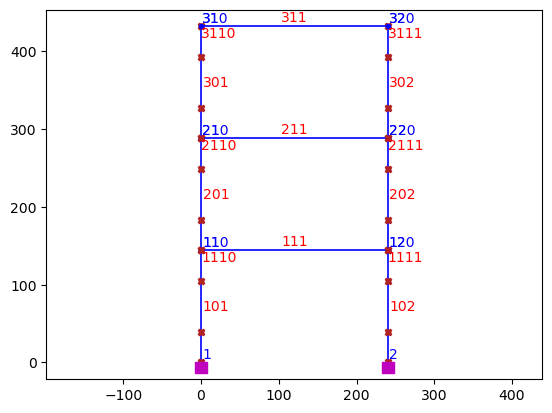

In [9]:
import opsvis as opsv

opsv.plot_model()

10090.869163818572

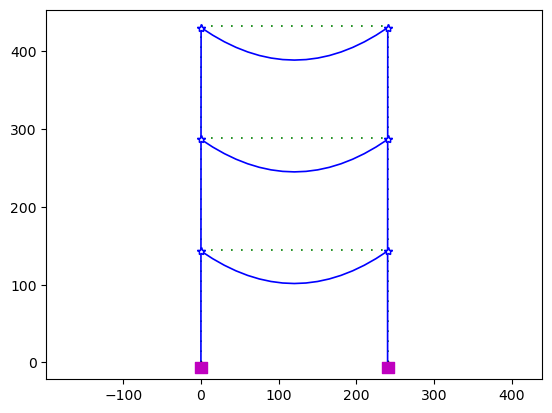

In [10]:
opsv.plot_defo()

(-0.0055940837254637, -0.0055940837254637, <Axes: >)

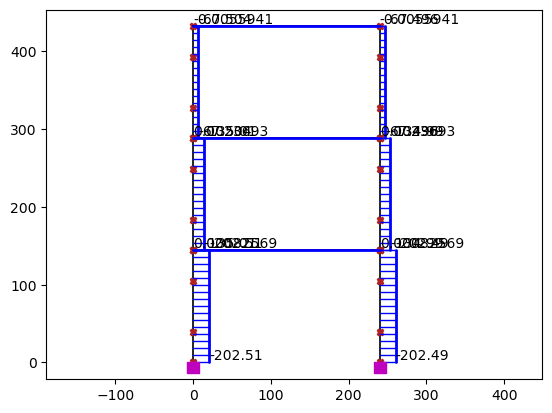

In [11]:
opsv.section_force_diagram_2d(sf_type='N', sfac=0.1)

### Modal Analysis

In [14]:
##################
# Start Analysis #
##################

ops.initialize()

##################
# Set Recorders  #
##################
nEigens = 3 # number of eigenvalues to compute
modalNodeTags = [11, 21, 31]

# ops.recorder('Node', '-file', 'modal_node_eigen1.out', '-time', '-node', *modalNodeTags, '-dof', 1,  'eigen 1')

# ops.recorder('Node', '-file', 'modal_node_eigen.out', '-time', '-node', *modalNodeTags, '-dof', 1,  'eigen', *[1, 2, 3])

for mode in range(1, nEigens + 1):
    ops.recorder('Node', '-file', f'modal_eigen{mode}.out', '-time', '-node', *modalNodeTags, '-dof', 1,  f'eigen {mode}')


####################
# Analysis Options #
####################

# Constraints handler
ops.constraints('Transformation')

# DOF numberer
ops.numberer('Plain')

# System of equations
ops.system('BandGen')

# Convergence test
ops.test('NormDispIncr', 1.0e-12, 25, 0, 2)

# Solution algorithm
ops.algorithm('Newton')

# Integrator
_gamma, _beta = 0.5, 0.25 # average constant acceleration (middle point rule)
ops.integrator('Newmark', _gamma, _beta, 'form', 'D')

# Analysis type
ops.analysis('Transient')

# Analyze the model
eigenValues = ops.eigen(nEigens) # λ
with open('modal_eigenvalues.out', 'w') as eigenID:
    eigenID.write(f"{'λ':>15} {'ω (rad/sec)':>15} {'T (sec)':>15} {'f (Hz)':>15}\n")
    for i, eigenVal in enumerate(eigenValues):
        omega = sqrt(eigenVal) # ω = √λ (rad/sec)
        period = 2 * pi / omega # T = 2π/ω (sec)
        freq = 1 / period if period != 0 else 0
        eigenID.write(f'{eigenVal:>15} {omega:>15} {period:>15} {freq:>15}\n')
        print(f'Mode {i+1}: Eigenvalue = {eigenVal:.6g}, Period = {period:.6g} sec')

# Record eigenvectors
ops.record()
        
# Reset for next analysis case
ops.setTime(0.0)
ops.loadConst()
ops.remove('recorders')
ops.wipeAnalysis()

# Combine records into single file and delete individual files
with open('modal_eigenvectors.out', 'w') as outfile:
    for mode in range(1, nEigens + 1):
        with open(f'modal_eigen{mode}.out', 'r') as infile:
            for line in infile:
                outfile.write(line)
        os.remove(f'modal_eigen{mode}.out')



Mode 1: Eigenvalue = 58.0677, Period = 0.824541 sec
Mode 2: Eigenvalue = 2492.63, Period = 0.125849 sec
Mode 3: Eigenvalue = 17996, Period = 0.0468374 sec


#### Visualize Mode Shapes

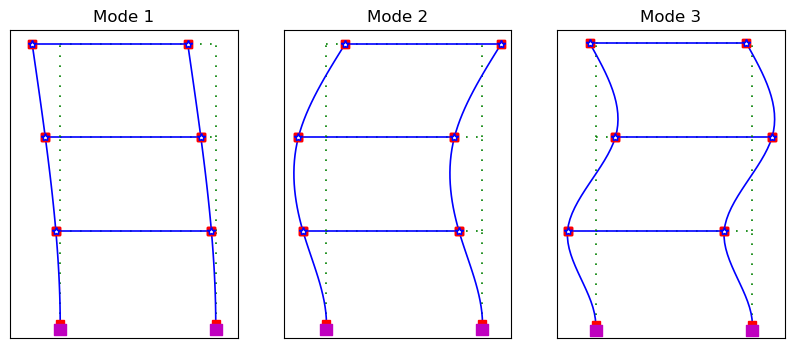

In [13]:
fig, axes = plt.subplots(1, nEigens, figsize=(10,4))
axes = axes.flatten()

for i, ax in enumerate(axes):
    opsv.plot_mode_shape(modeNo=i+1, ax=ax)
    ax.set_title(f'Mode {i+1}')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)